# ベイズ線形回帰 (Bayesian linear regression)

In [1]:
using Base: @kwdef
using Parameters: @unpack
using PyPlot, LinearAlgebra, Random, Distributions
rc("axes.spines", top=false, right=false)

In [2]:
# Generate Toy datas
num_train, num_test = 20, 100 # sample size
dims = 4 # dimensions
σy = 0.3

polynomial_expansion(x; degree=3) = hcat([x .^ p for p in 0:degree]...);

Random.seed!(0);
x = rand(num_train)
y = sin.(2π*x) + σy * randn(num_train);
ϕ = polynomial_expansion(x, degree=dims-1) # design matrix

xtest = range(-0.1, 1.1, length=num_test)
ytest = sin.(2π*xtest)
ϕtest = polynomial_expansion(xtest, degree=dims-1);

conjugate prior

$$
p(\mathbf{w})=\mathcal{N}(\mathbf{w}|\boldsymbol{\mu}_0, \mathbf{\Sigma}_0)
$$

posterior

$$
p(\mathbf{w}|\mathbf{Y}, \mathbf{X})=\mathcal{N}(\mathbf{w}|\hat{\boldsymbol{\mu}}, \hat{\mathbf{\Sigma}})
$$

ただし，

$$
\begin{align}
\hat{\mathbf{\Sigma}}^{-1}&= \mathbf{\Sigma}_0^{-1}+ \beta \Phi^\top\Phi\\
\hat{\boldsymbol{\mu}}&=\Sigma_N (\mathbf{\Sigma}_0^{-1}\boldsymbol{\mu}_0+\beta \Phi^\top \mathbf{y})
\end{align}
$$

である．また，$\Phi=\phi.(\mathbf{x})$であり，$\phi(x)=[1, x, x^2, x^3]$, $\boldsymbol{\mu}_0=\mathbf{0}, \mathbf{\Sigma}_0= \alpha^{-1} \mathbf{I}$とする．

テストデータを$\mathbf{x}^*$とした際，予測分布は

$$
p(y^*|\mathbf{x}^*, \mathbf{Y}, \mathbf{X})=\mathcal{N}(y^*|\boldsymbol{\mu}^*, \mathbf{\Sigma}^*)
$$

となる．ただし，

$$
\begin{align}
\boldsymbol{\mu}^*&=\hat{\boldsymbol{\mu}}^\top \phi(\mathbf{x}^*)\\
\mathbf{\Sigma}^* &= \frac{1}{\beta} +  \phi(\mathbf{x}^*)^\top\hat{\mathbf{\Sigma}}\phi(\mathbf{x}^*)\\
\end{align}
$$

In [3]:
@kwdef mutable struct BayesianLinearReg
    μ̂::Array
    Σ̂::Array
end

# Training params & definition of model
function BayesianLinearReg(ϕ, y, α, β)
    Σ̂ = inv(α * I + β * ϕ' * ϕ)
    μ̂ = β * Σ̂  * ϕ' * y;
    return BayesianLinearReg(μ̂=μ̂, Σ̂=Σ̂)
end;

function predict(ϕ, blr::BayesianLinearReg, β)
    @unpack μ̂, Σ̂ = blr
    μp = ϕ * μ̂
    σp = sqrt.(1/β .+ diag(ϕ * Σ̂ * ϕ'));
    return μp, σp
end;

function sampling_func(ϕ, blr::BayesianLinearReg, num_sampling::Int)
    @unpack μ̂, Σ̂ = blr
    dist = MvNormal(μ̂, Matrix(Hermitian(Σ̂)))
    sampled_params = rand(dist, num_sampling);
    return ϕ * sampled_params 
end;

In [4]:
α, β = 1e-3, 5.0;

blr = BayesianLinearReg(ϕ, y, α, β);
μtest, σtest = predict(ϕtest, blr, β);

num_sampling = 5
sampled_func = sampling_func(ϕtest, blr, num_sampling);

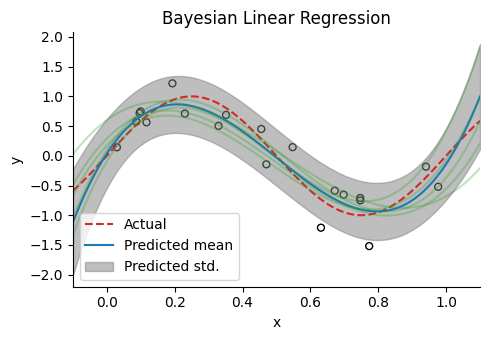

In [5]:
figure(figsize=(5,3.5))
title("Bayesian Linear Regression")
scatter(x, y, facecolor="None", edgecolors="black", s=25) # samples
plot(xtest, ytest, "--", label="Actual", color="tab:red")  # regression line
plot(xtest, μtest, label="Predicted mean", color="tab:blue")  # regression line
fill_between(xtest, μtest+σtest, μtest-σtest, alpha=0.5, color="tab:gray", label="Predicted std.")
for i in 1:num_sampling
    plot(xtest, sampled_func[:, i], alpha=0.3, color="tab:green")
end
xlabel("x"); ylabel("y"); legend()
xlim(-0.1, 1.1); tight_layout()